# ICL vs Traditional Machine learning algorithms

### Importing the important libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Load California housing dataset
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["MedHouseVal"] = data.target

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Select 20 samples from test set for evaluation
sample_test = test_df.sample(20, random_state=42)

In [2]:
def create_prompt(train_data, test_sample):
    prompt = "Predict California housing prices based on input features.\n\n"

    for _, row in train_data.iterrows():
        features = ", ".join([f"{col}: {row[col]:.2f}" for col in data.feature_names])
        prompt += f"Input: {features} => Target: {row['MedHouseVal']:.2f}\n"

    test_features = ", ".join([f"{col}: {test_sample[col]:.2f}" for col in data.feature_names])
    prompt += f"\nNow predict for:\nInput: {test_features}\nOnly return the predicted number."

    return prompt

In [3]:
import subprocess

def query_model(prompt: str) -> float:
    """
    Calls Mistral locally using Ollama.
    Ensure you have: ollama pull mistral
    """
    try:
        result = subprocess.run(
            ["ollama", "run", "mistral"],
            input=prompt.encode("utf-8"),
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            timeout=60
        )
        output = result.stdout.decode("utf-8").strip()
        print("--- Model Output ---\n", output)
        # Try to extract first float in output
        prediction = float(output.split()[0])
        return prediction
    except Exception as e:
        print("Failed to get prediction:", e)
        return np.nan

In [ ]:
import time

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import time

results = []

for k in range(10, 101, 10):
    print(f"\n=== Using {k} examples ===")
    few_shot = train_df.sample(k, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_k = scaler.fit_transform(few_shot[data.feature_names])
    y_k = few_shot["MedHouseVal"].values
    X_test = scaler.transform(sample_test[data.feature_names])
    y_test = sample_test["MedHouseVal"].values

    # Define models to compare
    models = {
        "Linear": LinearRegression(),
        "Ridge": Ridge(alpha=1.0),
        "Lasso": Lasso(alpha=0.1),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
        "SVR": SVR(kernel="rbf", C=1.0)
    }

    metrics = {}
    compute_times = {}

    for name, model in models.items():
        start_time = time.time()
        model.fit(X_k, y_k)
        preds = model.predict(X_test)
        elapsed = time.time() - start_time

        mae = mean_absolute_error(y_test, preds)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, preds)

        metrics[name] = (mae, mse, rmse, r2)
        compute_times[name] = elapsed

        print(f"{name:<15} -> MAE: {mae:.4f} | Time: {elapsed:.2f}s")

    # Run ICL predictions and record time
    start_time = time.time()
    icl_preds = [query_model(create_prompt(few_shot, row)) for _, row in sample_test.iterrows()]
    icl_elapsed = time.time() - start_time

    icl_clean = [(p, t) for p, t in zip(icl_preds, y_test) if not np.isnan(p)]
    if icl_clean:
        icl_p, icl_t = zip(*icl_clean)
        icl_mae = mean_absolute_error(icl_t, icl_p)
        icl_mse = mean_squared_error(icl_t, icl_p)
        icl_rmse = np.sqrt(icl_mse)
        icl_r2 = r2_score(icl_t, icl_p)
    else:
        icl_mae = icl_mse = icl_rmse = icl_r2 = np.nan

    print(f"ICL (Text)      -> MAE: {icl_mae:.4f} | Time: {icl_elapsed:.2f}s")

    # Save metrics and compute times
    results.append(
        (k,)
        + tuple(v for name in models.keys() for v in metrics[name])
        + (icl_mae, icl_mse, icl_rmse, icl_r2)
        + tuple(compute_times[name] for name in models.keys())
        + (icl_elapsed,)
    )


=== Using 10 examples ===
Linear          -> MAE: 1.5662 | Time: 0.00s
Ridge           -> MAE: 1.0169 | Time: 0.00s
Lasso           -> MAE: 0.9732 | Time: 0.00s
RandomForest    -> MAE: 0.8034 | Time: 0.07s
GradientBoosting -> MAE: 1.0559 | Time: 0.02s
SVR             -> MAE: 0.9041 | Time: 0.00s
--- Model Output ---
 2.51 (This is a prediction based on linear regression model trained on the provided data and the given input features. It is not guaranteed to be accurate.)
--- Model Output ---
 2.43 (Prediction based on linear regression using provided data as an example)
--- Model Output ---
 2.78 (Prediction based on linear regression model fitted from your provided data)
--- Model Output ---
 2.74 (This is a prediction based on the given data and does not guarantee accuracy. Actual results may vary.)
--- Model Output ---
 2.37 (This is an approximate prediction based on the given data and using linear regression or similar methods for prediction.)
--- Model Output ---
 2.56 (This is 

In [1]:
import pandas as pd
import os

# Define columns matching your results
columns = ["k"]
for model in models.keys():
    columns.extend([f"{model}_MAE", f"{model}_MSE", f"{model}_RMSE", f"{model}_R2"])
columns.extend(["ICL_MAE", "ICL_MSE", "ICL_RMSE", "ICL_R2"])
for model in models.keys():
    columns.append(f"{model}_Time_s")
columns.append("ICL_Time_s")
columns.append("ICL_Tokens")  # If you're tracking tokens

df = pd.DataFrame(results, columns=columns)
print(df.head())

# Define separate folders
csv_folder = "results_csv"
os.makedirs(csv_folder, exist_ok=True)

# Versioning inside CSV folder
base_name = "results_v"
ext = ".csv"

existing_files = [f for f in os.listdir(csv_folder) if f.startswith(base_name) and f.endswith(ext)]
if existing_files:
    versions = [int(f[len(base_name):-len(ext)]) for f in existing_files]
    next_version = max(versions) + 1
else:
    next_version = 1

file_name = f"{base_name}{next_version}{ext}"
file_path = os.path.join(csv_folder, file_name)
df.to_csv(file_path, index=False)

print(f"\n Results saved to: {file_path}")

NameError: name 'models' is not defined

Loaded latest results from: results_v2.csv


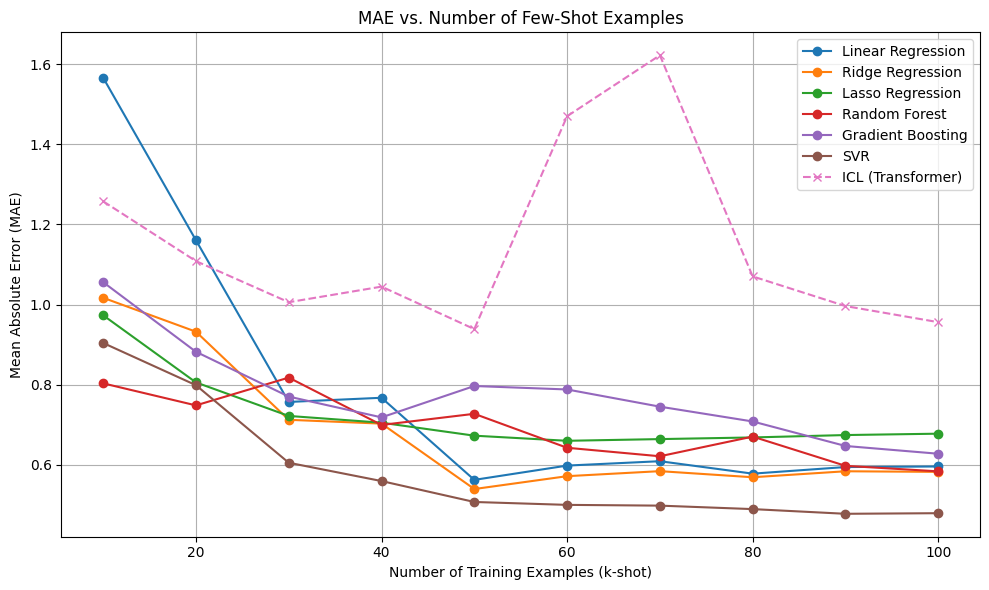

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Folders
csv_folder = "results_csv"
plots_folder = "results_plots"
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(plots_folder, exist_ok=True)

# Define base name and extension
base_name = "results_v"
ext = ".csv"

# Find the latest CSV in /results_csv/
existing_files = [f for f in os.listdir(csv_folder) if f.startswith(base_name) and f.endswith(ext)]

if existing_files:
    versions = [int(f[len(base_name):-len(ext)]) for f in existing_files]
    latest_version = max(versions)
    latest_file = f"{base_name}{latest_version}{ext}"
    csv_path = os.path.join(csv_folder, latest_file)

    df_latest = pd.read_csv(csv_path)
    print(f"✅ Loaded latest results from: {csv_path}")

    # Make versioned plots folder, e.g. /results_plots/v1/
    version_plots_folder = os.path.join(plots_folder, f"v{latest_version}")
    os.makedirs(version_plots_folder, exist_ok=True)

    # === MAE plot ===
    plt.figure(figsize=(10, 6))
    models_list = ["Linear", "Ridge", "Lasso", "RandomForest", "GradientBoosting", "SVR"]

    for model in models_list:
        plt.plot(df_latest['k'], df_latest[f'{model}_MAE'], marker='o', label=model)
    plt.plot(df_latest['k'], df_latest['ICL_MAE'], marker='x', linestyle='--', label='ICL (Transformer)')

    plt.title('Mean Absolute Error vs. Number of Few-Shot Examples')
    plt.xlabel('Number of Few-Shot Examples (k)')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    mae_plot_path = os.path.join(version_plots_folder, f"MAE_vs_k_v{latest_version}.png")
    plt.savefig(mae_plot_path, dpi=300)
    plt.close()
    print(f"✅ Saved MAE plot to: {mae_plot_path}")

    # === Compute Time plot ===
    plt.figure(figsize=(10, 6))
    for model in models_list:
        plt.plot(df_latest['k'], df_latest[f'{model}_Time_s'], marker='o', label=f"{model} Time")
    plt.plot(df_latest['k'], df_latest['ICL_Time_s'], marker='x', linestyle='--', label='ICL (Transformer) Time')

    plt.title('Compute Time vs. Number of Few-Shot Examples')
    plt.xlabel('Number of Few-Shot Examples (k)')
    plt.ylabel('Compute Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    time_plot_path = os.path.join(version_plots_folder, f"ComputeTime_vs_k_v{latest_version}.png")
    plt.savefig(time_plot_path, dpi=300)
    plt.close()
    print(f"✅ Saved Compute Time plot to: {time_plot_path}")

else:
    print("❌ No results files found in /results_csv/.")

✅ Loaded latest results from: results_v2.csv



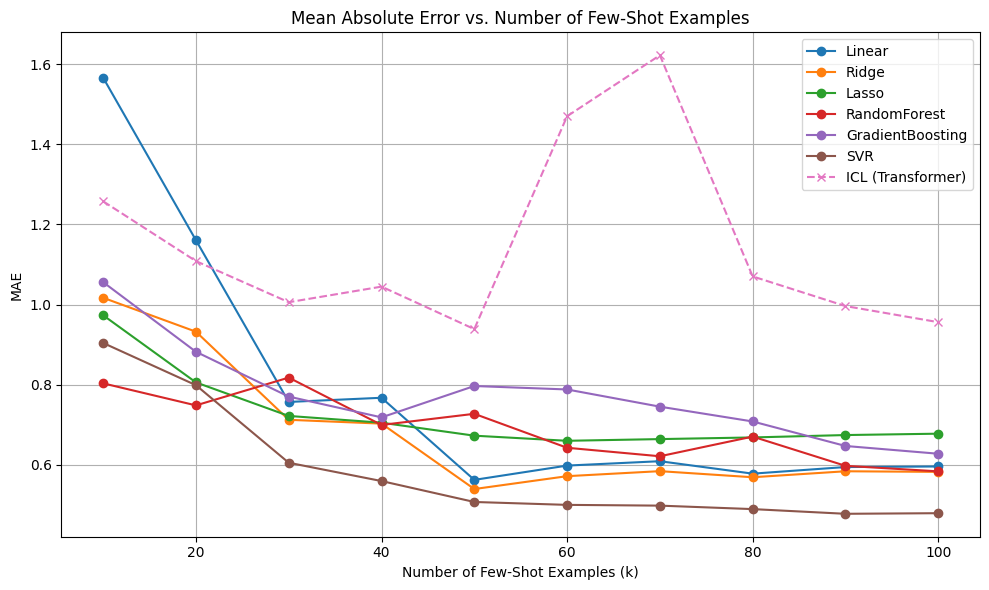

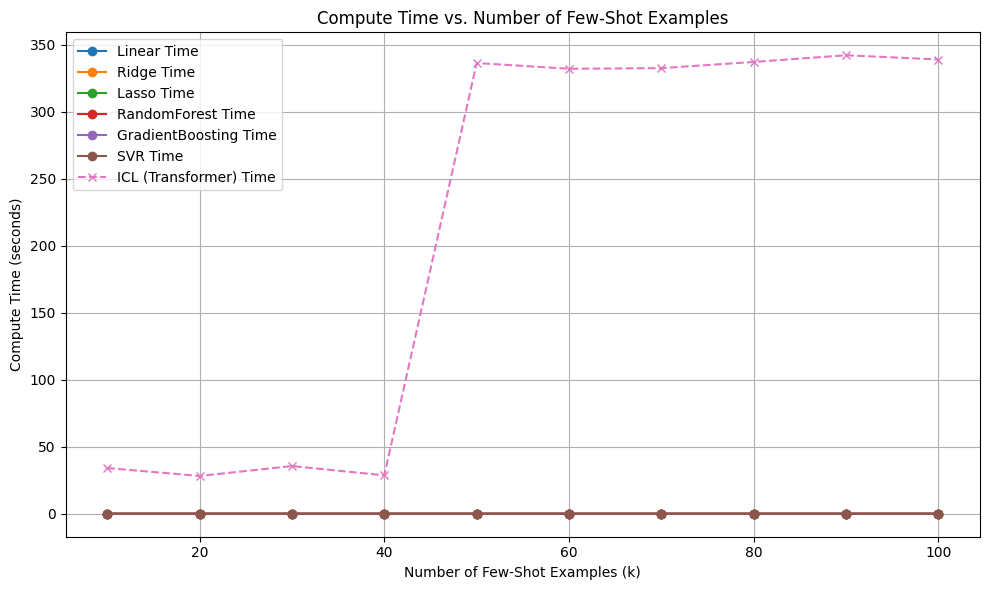

=== Average Compute Time (seconds) ===
Linear            : 0.00 s
Ridge             : 0.00 s
Lasso             : 0.00 s
RandomForest      : 0.07 s
GradientBoosting  : 0.03 s
SVR               : 0.00 s
ICL (Transformer) : 214.58 s


In [18]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Define base name and extension to match your saved files
base_name = "results_v"
ext = ".csv"

# Find the latest version
existing_files = [f for f in os.listdir('.') if f.startswith(base_name) and f.endswith(ext)]

if existing_files:
    versions = [int(f[len(base_name):-len(ext)]) for f in existing_files]
    latest_version = max(versions)
    latest_file = f"{base_name}{latest_version}{ext}"

    df_latest = pd.read_csv(latest_file)
    print(f"✅ Loaded latest results from: {latest_file}\n")

    # -------- PLOT 1: MAE vs k --------
    plt.figure(figsize=(10, 6))
    models_list = ["Linear", "Ridge", "Lasso", "RandomForest", "GradientBoosting", "SVR"]

    for model in models_list:
        plt.plot(df_latest['k'], df_latest[f'{model}_MAE'], marker='o', label=model)

    plt.plot(df_latest['k'], df_latest['ICL_MAE'], marker='x', linestyle='--', label='ICL (Transformer)')

    plt.title('Mean Absolute Error vs. Number of Few-Shot Examples')
    plt.xlabel('Number of Few-Shot Examples (k)')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # -------- PLOT 2: Compute Time vs k --------
    plt.figure(figsize=(10, 6))

    for model in models_list:
        plt.plot(df_latest['k'], df_latest[f'{model}_Time_s'], marker='o', label=f"{model} Time")

    plt.plot(df_latest['k'], df_latest['ICL_Time_s'], marker='x', linestyle='--', label='ICL (Transformer) Time')

    plt.title('Compute Time vs. Number of Few-Shot Examples')
    plt.xlabel('Number of Few-Shot Examples (k)')
    plt.ylabel('Compute Time (seconds)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # -------- Summary: Average Compute Time --------
    print("=== Average Compute Time (seconds) ===")
    for model in models_list:
        avg_time = df_latest[f"{model}_Time_s"].mean()
        print(f"{model:<18}: {avg_time:.2f} s")
    icl_avg_time = df_latest["ICL_Time_s"].mean()
    print(f"ICL (Transformer) : {icl_avg_time:.2f} s")

else:
    print("❌ No results files found.")

In [19]:
import matplotlib.pyplot as plt
import os

# Use the same models list
models_list = ["Linear", "Ridge", "Lasso", "RandomForest", "GradientBoosting", "SVR"]

# -------- Save PLOT 1: MAE vs k --------
plt.figure(figsize=(10, 6))
for model in models_list:
    plt.plot(df_latest['k'], df_latest[f'{model}_MAE'], marker='o', label=model)
plt.plot(df_latest['k'], df_latest['ICL_MAE'], marker='x', linestyle='--', label='ICL (Transformer)')

plt.title('Mean Absolute Error vs. Number of Few-Shot Examples')
plt.xlabel('Number of Few-Shot Examples (k)')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()

mae_plot_name = f"MAE_vs_k_v{latest_version}.png"
plt.savefig(mae_plot_name, dpi=300)
plt.close()
print(f"✅ Saved MAE plot to: {mae_plot_name}")

# -------- Save PLOT 2: Compute Time vs k --------
plt.figure(figsize=(10, 6))
for model in models_list:
    plt.plot(df_latest['k'], df_latest[f'{model}_Time_s'], marker='o', label=f"{model} Time")
plt.plot(df_latest['k'], df_latest['ICL_Time_s'], marker='x', linestyle='--', label='ICL (Transformer) Time')

plt.title('Compute Time vs. Number of Few-Shot Examples')
plt.xlabel('Number of Few-Shot Examples (k)')
plt.ylabel('Compute Time (seconds)')
plt.legend()
plt.grid(True)
plt.tight_layout()

time_plot_name = f"ComputeTime_vs_k_v{latest_version}.png"
plt.savefig(time_plot_name, dpi=300)
plt.close()
print(f"✅ Saved Compute Time plot to: {time_plot_name}")

✅ Saved MAE plot to: MAE_vs_k_v2.png
✅ Saved Compute Time plot to: ComputeTime_vs_k_v2.png
